In [1]:
import re
import itertools
import networkx as nx
import pandas as pd

gmd_dict = {
    "metric"     : { 
        'MSRP'              : ['msrp'],
        'ASP'               : ['asp'], 
        'Sales'             : [r'sales?'],  
        'Promo Value'             : ['promo value'], 
        'Traffic'           : ['Traffic'],
        'Search Trend'      : ['Trend'],
        'Consumer Sentiment' : ['Sentiment'],
        'week of supply': ['week of supply', 'wos'],

    },

    
    "dimensions" : {
       'Date'                   :[r'Dates?'], 
       'Week'                   :[r'weeks?'], 
       'City'                   :['city'], 
       'Location 1'              :['territory'], 
       'Location 2'                 :['region'], 
       'State'                  :['state'], 
       'Store Name'             :['store name'],
       'TSM'                    :['tsm'],
       'Coverage'               :['coverage'],
       'Tiering'                :['tiering'],
       'Quarter'                :['quarter'],
       'Trafic Breakdown'       :['traffic breakdown'],
       'visit_count'            :['visit count', 'visits?'],  
       'Effective Offer'        :['effective offer'],
       'Promo Type'             :['promo type'],
       'Price Segment'          :['Price Segment'], 
       'Brand'                  :['brand'],
       'Product Name'           :['product name'],
       'Partner'                :['partner'],
       'Country'                :['country'], 
       'Release Date'           :['Launch Date'] 
    },
    "ID" : [r'\_?ID', r'\bUID\b']
}

GLOBAL_LOCATIONS_SIGNIFIERS  = ['Location 1', 'Location 2']

In [2]:
import json
import os
from src.Utils.Config import GMD_DICT_PATH
# with open(os.path.join('src/', GMD_DICT_PATH, 'gmd_dict.json'), 'w') as fp:
#     json.dump(gmd_dict, fp)

# Add with MetaData (Aliases) 

In [3]:

df1 = pd.DataFrame({ 'ID': [1, 2, 3, 4], 'Sales': [11, 23, 32, 11], 'Partner': ['a', 'b', 'c', 'd'], 'Promo': [11, 23, 32, 11], 'MSRP': [11, 23, 32, 11], 'ASP': [11, 23, 32, 11]})
df2 = pd.DataFrame({'ID': [1, 2, 3], 'Sales': [11, 23, 32], 'Visits': [1, 2, 0], 'Partner': ['a', 'b', 'c'], 'Traffic': [1, 2, 3]})
df3 = pd.DataFrame({'ID': [1, 2, 3], 'Promo': [11, 23, 32], 'Visits': [1, 2, 0], 'Partner': ['a', 'b', 'c'], 'Traffic': [1, 2, 3]})
df4 = pd.DataFrame({'ID': [1, 2, 3], 'GFA': [11, 23, 32], 'Sales': [11, 23, 32], 'ASP': [11, 23, 32]})

df1_aliases = {'ID':[],'Sales': ['sales'], 'Partner': ['partner'], 'Promo': ['promo'], 'MSRP': ['msrp'], 'ASP': ['asp']}
df2_aliases = {'ID':[],'Sales': ['sales data', 'sales'], 'Visits': ['visits'], 'Partner': ['partner'], 'Traffic': ['traffic']}
df3_aliases = {'ID':[],'Promo': ['promo data', 'promo'], 'Visits': ['visits'], 'Partner': ['partner'], 'Traffic': ['traffic']}
df4_aliases = {'ID':[],'GFA': ['gfa'], 'Sales': ['sales data', 'sales'], 'ASP': ['asp']}

dfs = [df1, df2, df3, df4]
alias_dfs= [df1_aliases, df2_aliases, df3_aliases, df4_aliases]

Added edge between ID and Sales
Added edge between ID and Partner
Added edge between ID and Promo
Added edge between ID and MSRP
Added edge between ID and ASP
Added edge between Sales and Partner
Added edge between Sales and Promo
Added edge between Sales and MSRP
Added edge between Sales and ASP
Added edge between Partner and Promo
Added edge between Partner and MSRP
Added edge between Partner and ASP
Added edge between Promo and MSRP
Added edge between Promo and ASP
Added edge between MSRP and ASP
{'file_names': ['file0']}
Updated edge between ID and Sales
{'file_names': ['file0']}
Updated edge between ID and Partner
Added edge between ID and Traffic
{'file_names': ['file0']}
Updated edge between Sales and Partner
Added edge between Sales and Traffic
Added edge between Partner and Traffic
{'file_names': ['file0']}
Updated edge between ID and Promo
{'file_names': ['file0', 'file1']}
Updated edge between ID and Partner
{'file_names': ['file1']}
Updated edge between ID and Traffic
{'fil

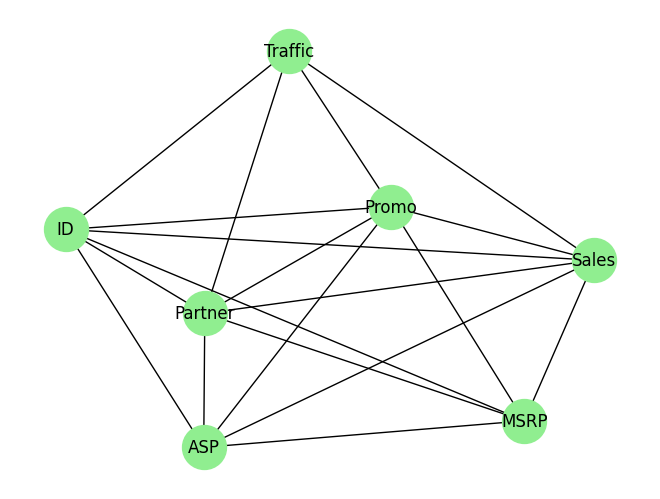

In [4]:
#Using Custom Example from above

graph= nx.Graph()

meta_data_dict = {'metric': {}, 'dimensions': {}}

def add_file_to_graph_and_generate_meta_data(df, aliases, file_name) -> None:
    global graph
    global meta_data_dict
    global gmd_dict
    
    list_of_metrics = []

    for column_name in aliases:
        aliasuses = aliases[column_name]
        regexes = [r"\b{}\b".format(alias) for alias in aliasuses + [column_name]]
        flag = 0

        # check if column_name in gmd_dict['metric']
        for metric_name, metric_regexes in gmd_dict['metric'].items():
            if any(re.search(r"\b{}\b".format(regex), metric_name, re.IGNORECASE) for regex in regexes) : #Current: we are finding from aliases to gmd_dict, another or condition could be gmd_dict regexes -> column_name match
                
                #if numeric, take mean val
                if pd.api.types.is_numeric_dtype(df[column_name]):
                    mval = [int(val) if val.dtype == 'int64' else float(val) for val in  [df[column_name].mean()]][0]
                    unique_values = [mval]                    
                elif pd.api.types.is_datetime64_any_dtype(df[column_name]):
                        min_date = df[column_name].min()
                        max_date = df[column_name].max()
                        unique_values = [min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d')]                 
                else:
                    unique_values = list(df[column_name].unique())
                meta_data_dict['metric'][column_name] = {'regexes': regexes+metric_regexes, 
                                                            'Unique Values': unique_values,
                                                            'GMD Name': metric_name}
                    
                flag = 1

                if not column_name in list_of_metrics:
                    list_of_metrics.append(column_name)

                if column_name not in graph:
                    graph.add_node(column_name, file_names=[file_name])

                else:
                    if file_name not in graph.nodes[column_name]['file_names']:
                        graph.nodes[column_name]['file_names'].append(file_name)
                break
        
        if flag == 0:
            for dimension_name, dimension_regexes in gmd_dict['dimensions'].items():
                if any(re.search(r"\b{}\b".format(regex), dimension_name, re.IGNORECASE) for regex in regexes):
                    # print(df)
                    
                    #if numeric, take mean val
                    if pd.api.types.is_numeric_dtype(df[column_name]):
                        mval = [int(val) if val.dtype == 'int64' else float(val) for val in  [df[column_name].mean()]][0]
                        unique_values = [mval]          
                    #date dtype          :
                    elif pd.api.types.is_datetime64_any_dtype(df[column_name]):
                        min_date = df[column_name].min()
                        max_date = df[column_name].max()
                        unique_values = [min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d')]
                    else:
                        unique_values = list(df[column_name].unique())
                    
                    meta_data_dict['dimensions'][column_name] = {'regexes': regexes+dimension_regexes,
                                                                    'Unique Values': unique_values,
                                                                    # 'Uni Vals': list(df[column_name].unique()),
                                                                    'GMD Name': dimension_name}

                    if not column_name in list_of_metrics:
                        list_of_metrics.append(column_name)

                    if column_name not in graph:
                        graph.add_node(column_name, file_names=[file_name])

                    else:
                        if file_name not in graph.nodes[column_name]['file_names']:
                            graph.nodes[column_name]['file_names'].append(file_name)
                    break
            if any([re.search(r"\b{}\b".format(regex), column_name, re.IGNORECASE) for regex in gmd_dict['ID']]):
                if column_name not in graph:
                    graph.add_node(column_name, file_names=[file_name])
                else:
                    if file_name not in graph.nodes[column_name]['file_names']:
                        graph.nodes[column_name]['file_names'].append(file_name)
                if not column_name in list_of_metrics:
                    list_of_metrics.append(column_name)
        
    if len(list_of_metrics)>=2:
        for node1, node2 in itertools.combinations(list_of_metrics, 2):
            # print(node1, node2)
            if not node1 == node2:
                if not graph.has_edge(node1, node2):
                    graph.add_edge(node1, node2, file_names=[file_name])
                    print('Added edge between {} and {}'.format(node1, node2))
                else:
                    print(graph.get_edge_data(node1, node2))
                    if file_name not in graph.edges[node1, node2]['file_names']:
                        graph.edges[node1, node2]['file_names'].append(file_name)
                    print('Updated edge between {} and {}'.format(node1, node2))

for i, j, k in zip(dfs, alias_dfs, range(len(dfs))):
    add_file_to_graph_and_generate_meta_data(i, j, f'file{k}')
    

# import os 
# for file in os.listdir('test_data'):
#     df = pd.read_parquet(f'test_data/{file}')
#     add_file_to_graph_and_generate_meta_data(df, file)


nx.draw(graph, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)

print('Node data')
for node in graph.nodes:
    print(node, graph.nodes[node])

print('Edge data')
for edge in graph.edges:
    print(edge, graph.edges[edge])

In [5]:
for key, meta_data in meta_data_dict['metric'].items():
    print(key, meta_data)

for key, meta_data in meta_data_dict['dimensions'].items():
    print(key, meta_data)

Sales {'regexes': ['\\bsales data\\b', '\\bsales\\b', '\\bSales\\b', 'sales?'], 'Unique Values': [22.0], 'GMD Name': 'Sales'}
Promo {'regexes': ['\\bpromo data\\b', '\\bpromo\\b', '\\bPromo\\b', 'promo value'], 'Unique Values': [22.0], 'GMD Name': 'Promo Value'}
MSRP {'regexes': ['\\bmsrp\\b', '\\bMSRP\\b', 'msrp'], 'Unique Values': [19.25], 'GMD Name': 'MSRP'}
ASP {'regexes': ['\\basp\\b', '\\bASP\\b', 'asp'], 'Unique Values': [22.0], 'GMD Name': 'ASP'}
Traffic {'regexes': ['\\btraffic\\b', '\\bTraffic\\b', 'Traffic'], 'Unique Values': [2.0], 'GMD Name': 'Traffic'}
Partner {'regexes': ['\\bpartner\\b', '\\bPartner\\b', 'partner'], 'Unique Values': ['a', 'b', 'c'], 'GMD Name': 'Partner'}


In [6]:
import json 
company_name = 'test'
with open('src/User_data/meta_datas/test_meta_data.json', 'w') as fp:
    json.dump(meta_data_dict, fp)

In [7]:
nx.write_gml(graph, f"src/User_data/graphs/{company_name}_graph.gml")


In [8]:
graph = nx.read_gml(f"{company_name}_graph.gml")
print('Node data')
for node in graph.nodes:
    print(node, graph.nodes[node])

print('Edge data')
for edge in graph.edges:
    print(edge, graph.edges[edge])
nx.draw(graph, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)


FileNotFoundError: [Errno 2] No such file or directory: 'test_graph.gml'

# Without Alias

In [3]:
from src.Utils.load_funcs import load_meta_data, load_gmd, load_graph

gmd = load_gmd()

In [4]:
##Config file
COLS_TO_ASK_OR_CHECK_PRESENCE_WHILE_ADDING_FOR_A_METRIC = {
    'Sales': ['Product Name', 'Date'],
    'Traffic': ['Product Name', 'Date'],
    'week of supply': ['Product Name', 'Date'],
    'MSRP': ['Product Name', 'Date'],
    'ASP': ['Product Name', 'Date'],
    'Promo Value': ['Product Name', 'Date'],
    'Search Trend': ['Product Name', 'Date'],
}

In [5]:
gmd_dict

{'metric': {'MSRP': ['msrp'],
  'ASP': ['asp'],
  'Sales': ['sales?'],
  'Promo Value': ['promo value'],
  'Traffic': ['Traffic'],
  'Search Trend': ['Trend'],
  'Consumer Sentiment': ['Sentiment'],
  'week of supply': ['week of supply', 'wos']},
 'dimensions': {'Date': ['Dates?'],
  'Week': ['weeks?'],
  'City': ['city'],
  'Location 1': ['territory'],
  'Location 2': ['region'],
  'State': ['state'],
  'Store Name': ['store name'],
  'TSM': ['tsm'],
  'Coverage': ['coverage'],
  'Tiering': ['tiering'],
  'Quarter': ['quarter'],
  'Trafic Breakdown': ['traffic breakdown'],
  'visit_count': ['visit count', 'visits?'],
  'Effective Offer': ['effective offer'],
  'Promo Type': ['promo type'],
  'Price Segment': ['Price Segment'],
  'Brand': ['brand'],
  'Product Name': ['product name'],
  'Partner': ['partner'],
  'Country': ['country'],
  'Release Date': ['Launch Date']},
 'ID': ['\\_?ID', '\\bUID\\b']}

In [3]:
'list_of_column_checks'.upper()

'LIST_OF_COLUMN_CHECKS'

In [6]:

def give_mappings(df, gmd_dict):
    # out= {}
    mapped = {}
    metrics = []
    flag = 0
    for col in df.columns:
        for metric, regexes in gmd_dict['metric'].items():
            print(col, metric, regexes)
            if any([re.search(r"\b{}\b".format(regex), col, re.IGNORECASE) for regex in regexes]):
                print(col, metric)
                mapped[col] = metric
                metrics.append(metric)
                flag = 1
                break
                
        if flag == 1:
            flag = 0
            continue

        for dimension, regexes in gmd_dict['dimensions'].items():
            if any([re.search(r"\b{}\b".format(regex), col, re.IGNORECASE) for regex in regexes]):
                mapped[col] = dimension
                break

        #ID Check
        if any([re.search(r"\b{}\b".format(regex), col, re.IGNORECASE) for regex in gmd_dict['ID']]):
            mapped[col] = 'ID'
    misc = []
    for metric in metrics:
        if metric in COLS_TO_ASK_OR_CHECK_PRESENCE_WHILE_ADDING_FOR_A_METRIC:
            if set(COLS_TO_ASK_OR_CHECK_PRESENCE_WHILE_ADDING_FOR_A_METRIC[metric]) - set(mapped.values()):
                misc+=list(set(COLS_TO_ASK_OR_CHECK_PRESENCE_WHILE_ADDING_FOR_A_METRIC[metric]) - set(mapped.values()))
    misc = list(set(misc))
    unmapped = [col for col in df.columns if col not in mapped.keys()]
    dataTypes = {}
    #string , number or date
    for col in df.columns:
        if df.dtypes[col] == 'object':
            if df[col].dtype == 'object':
                
                try:
                    df[col] = pd.to_datetime(df[col])
                    dataTypes[col] = 'date'
                except ValueError:
                    dataTypes[col] = 'string'

        elif df.dtypes[col] == 'int64' or dataTypes[col] == 'float64':
            dataTypes[col] = 'number'
        else:
            dataTypes[col] = 'string'
    return {'dataTypes': dataTypes, 'Mapped': mapped,'Unmapped': unmapped, 'Misc_needed': misc}

In [7]:
df = pd.read_csv(r'D:\Smollan\titan_repo\titan\server\src\User_data\file_datas\Traffic_data_dummy_19_aug.csv')
df

,Ice Id,Store Id,Date,Week,Partner Name,Traffic
0,1,1,2024-01-01,48,Costco,5825460
1,2,2,2024-02-01,27,Costco,9656464
2,3,3,2024-01-01,23,Amazon,2010354
3,4,4,2024-01-01,1,Target,6388783
4,5,5,2024-02-01,26,Target,2616359
...,...,...,...,...,...,...
295,296,296,2024-03-01,22,Costco,713561
296,297,297,2024-01-01,26,Walmart,1995656
297,298,298,2024-02-01,49,Amazon,1558718
298,299,299,2024-02-01,19,Walmart,9307585


In [8]:
mappings = give_mappings(df, gmd_dict)
mappings

Ice Id MSRP ['msrp']
Ice Id ASP ['asp']
Ice Id Sales ['sales?']
Ice Id Promo Value ['promo value']
Ice Id Traffic ['Traffic']
Ice Id Search Trend ['Trend']
Ice Id Consumer Sentiment ['Sentiment']
Ice Id week of supply ['week of supply', 'wos']
Store Id MSRP ['msrp']
Store Id ASP ['asp']
Store Id Sales ['sales?']
Store Id Promo Value ['promo value']
Store Id Traffic ['Traffic']
Store Id Search Trend ['Trend']
Store Id Consumer Sentiment ['Sentiment']
Store Id week of supply ['week of supply', 'wos']
Date MSRP ['msrp']
Date ASP ['asp']
Date Sales ['sales?']
Date Promo Value ['promo value']
Date Traffic ['Traffic']
Date Search Trend ['Trend']
Date Consumer Sentiment ['Sentiment']
Date week of supply ['week of supply', 'wos']
Week MSRP ['msrp']
Week ASP ['asp']
Week Sales ['sales?']
Week Promo Value ['promo value']
Week Traffic ['Traffic']
Week Search Trend ['Trend']
Week Consumer Sentiment ['Sentiment']
Week week of supply ['week of supply', 'wos']
Partner Name MSRP ['msrp']
Partner Name 

C:\Users\Midrian\AppData\Local\Temp\ipykernel_21268\4237774110.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


{'dataTypes': {'Ice Id': 'number',
  'Store Id': 'number',
  'Date': 'date',
  'Week': 'number',
  'Partner Name': 'string',
  'Traffic': 'number'},
 'Mapped': {'Ice Id': 'ID',
  'Store Id': 'ID',
  'Date': 'Date',
  'Week': 'Week',
  'Partner Name': 'Partner',
  'Traffic': 'Traffic'},
 'Unmapped': [],
 'Misc_needed': ['Product Name']}

In [16]:
def add_mappings_to_graph_and_meta_data(mappings, df, file_name, gmd_dict, graph, meta_store, id_graph):
    #Add nodes for each metric if it doesn't exist else add the file name to the list of file names
    node_list = mappings['Mapped']
    id_cols = []
    flag = 0
    # gmd_names = node_list.values()

    for node in node_list:
        if node not in graph:
            if pd.api.types.is_numeric_dtype(df[node]):
                mval = [int(val) if val.dtype == 'int64' else float(val) for val in  [df[node].mean()]][0]
                unique_values = [mval]                    
            elif pd.api.types.is_datetime64_any_dtype(df[node]):
                min_date = df[node].min()
                max_date = df[node].max()
                unique_values = [min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d')]
            else:
                unique_values = list(df[node].unique())
            
            graph.add_node(node, file_names=[file_name])
            id_graph.add_node(node, file_names=[file_name])
        else:
            if file_name not in graph.nodes[node]['file_names']:
                graph.nodes[node]['file_names'].append(file_name)
            if file_name not in id_graph.nodes[node]['file_names']:
                id_graph.nodes[node]['file_names'].append(file_name)

        if not node in meta_store['metric'] and node_list[node] in gmd_dict['metric']:
            meta_store['metric'][node] = {'regexes': list(set(gmd_dict['metric'][node_list[node]] + [node.lower()])),'Unique Values': unique_values, 'GMD Name': node_list[node]}
        elif not node in meta_store['dimensions'] and node_list[node] in gmd_dict['dimensions']:
            meta_store['dimensions'][node] = {'regexes': list(set(gmd_dict['dimensions'][node_list[node]] + [node.lower()])),'Unique Values': unique_values, 'GMD Name': node_list[node]}
        
        if node_list[node] in GLOBAL_LOCATIONS_SIGNIFIERS:
            if node not in meta_store['Location Cols']:
                meta_store['Location Cols'][node] = {'GMD Name': node_list[node]}
        if node_list[node] == 'ID':
            id_cols.append(node)
    
    for node1, node2 in itertools.combinations(node_list.keys(), 2):
            print(node1, node2)
            if not node1 == node2:
                if not graph.has_edge(node1, node2):
                    graph.add_edge(node1, node2, file_names=[file_name])
                    print('Added edge between {} and {}'.format(node1, node2))
                else:
                    print(graph.get_edge_data(node1, node2))
                    if file_name not in graph.edges[node1, node2]['file_names']:
                        # graph.edges[node1, node2]['file_names'][file_name] = col
                        graph.edges[node1, node2]['file_names'].append(file_name)
                    print('Updated edge between {} and {}'.format(node1, node2))
                if node1 in id_cols or node2 in id_cols:
                    if not id_graph.has_edge(node1, node2):
                        id_graph.add_edge(node1, node2, file_names=[file_name])
                        print('Added id grph edge between {} and {}'.format(node1, node2))
                    else:
                        print(id_graph.get_edge_data(node1, node2))
                        if file_name not in id_graph.edges[node1, node2]['file_names']:
                            # graph.edges[node1, node2]['file_names'][file_name] = col
                            id_graph.edges[node1, node2]['file_names'].append(file_name)
                        print('Updated id grph edge between {} and {}'.format(node1, node2))
    
    meta_store['Misc_info'][file_name]=mappings['Misc_needed']
    
    return graph, id_graph, meta_store

In [17]:
graph= load_graph('None')
id_graph = nx.Graph()
meta_store = load_meta_data('None')

Graph path error , initializing with empty d:\Smollan\titan_repo\titan\server\src\Utils\..\User_data/graphs\None
Meta data path error, initializing with empty  d:\Smollan\titan_repo\titan\server\src\Utils\..\User_data/meta_datas\None


Ice Id Store Id
Added edge between Ice Id and Store Id
Added id grph edge between Ice Id and Store Id
Ice Id Date
Added edge between Ice Id and Date
Added id grph edge between Ice Id and Date
Ice Id Week
Added edge between Ice Id and Week
Added id grph edge between Ice Id and Week
Ice Id Partner Name
Added edge between Ice Id and Partner Name
Added id grph edge between Ice Id and Partner Name
Ice Id Traffic
Added edge between Ice Id and Traffic
Added id grph edge between Ice Id and Traffic
Store Id Date
Added edge between Store Id and Date
Added id grph edge between Store Id and Date
Store Id Week
Added edge between Store Id and Week
Added id grph edge between Store Id and Week
Store Id Partner Name
Added edge between Store Id and Partner Name
Added id grph edge between Store Id and Partner Name
Store Id Traffic
Added edge between Store Id and Traffic
Added id grph edge between Store Id and Traffic
Date Week
Added edge between Date and Week
Date Partner Name
Added edge between Date and

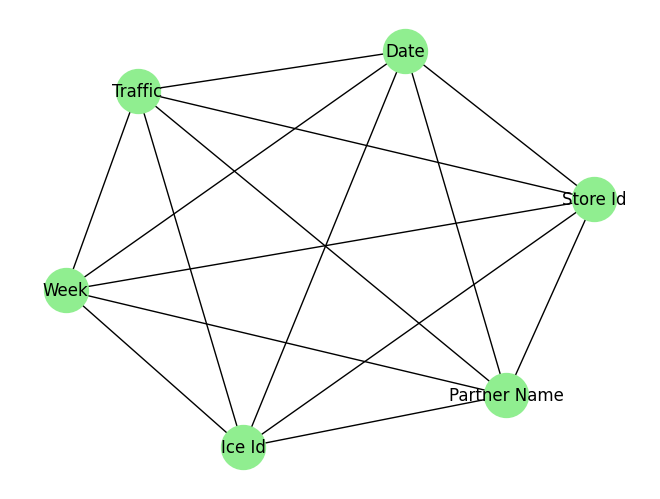

In [11]:
graph, id_graph, meta_store = add_mappings_to_graph_and_meta_data(mappings, df, 'test', gmd_dict, graph, meta_store, id_graph)

nx.draw(graph, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)

Graph path error , initializing with empty d:\Smollan\titan_repo\titan\server\src\Utils\..\User_data/graphs\None
Meta data path error, initializing with empty  d:\Smollan\titan_repo\titan\server\src\Utils\..\User_data/meta_datas\None
City MSRP ['msrp']
City ASP ['asp']
City Sales ['sales?']
City Promo Value ['promo value']
City Traffic ['Traffic']
City Search Trend ['Trend']
City Consumer Sentiment ['Sentiment']
City week of supply ['week of supply', 'wos']
Territory MSRP ['msrp']
Territory ASP ['asp']
Territory Sales ['sales?']
Territory Promo Value ['promo value']
Territory Traffic ['Traffic']
Territory Search Trend ['Trend']
Territory Consumer Sentiment ['Sentiment']
Territory week of supply ['week of supply', 'wos']
State MSRP ['msrp']
State ASP ['asp']
State Sales ['sales?']
State Promo Value ['promo value']
State Traffic ['Traffic']
State Search Trend ['Trend']
State Consumer Sentiment ['Sentiment']
State week of supply ['week of supply', 'wos']
Region MSRP ['msrp']
Region ASP ['

C:\Users\Midrian\AppData\Local\Temp\ipykernel_21268\4237774110.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\Midrian\AppData\Local\Temp\ipykernel_21268\4237774110.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\Midrian\AppData\Local\Temp\ipykernel_21268\4237774110.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\Midrian\AppData\Local\Temp\ipykernel_21268\4237774110.py:42: UserWarning: Could not infer format, so each element will be

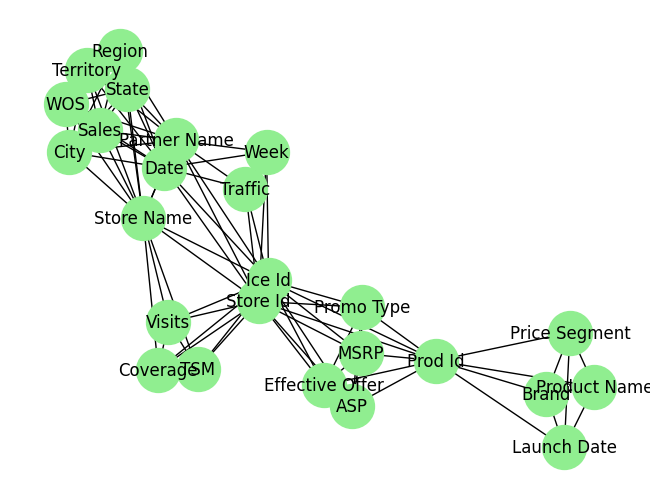

In [12]:
graph= load_graph('None')
id_graph = nx.Graph()
meta_store = load_meta_data('None')

for file in os.listdir('src/User_data/file_datas'):
    df = pd.read_csv(f'src/User_data/file_datas/{file}')
    mappings = give_mappings(df, gmd)
    print(mappings)
    graph, id_graph, meta_store = add_mappings_to_graph_and_meta_data(mappings, df, file, gmd_dict, graph, meta_store, id_graph)

nx.draw(graph, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)

Node data
City {'file_names': ['Dummy_data_wos_sales.csv']}
Territory {'file_names': ['Dummy_data_wos_sales.csv']}
State {'file_names': ['Dummy_data_wos_sales.csv']}
Region {'file_names': ['Dummy_data_wos_sales.csv']}
Partner Name {'file_names': ['Dummy_data_wos_sales.csv', 'Traffic_data_dummy_19_aug.csv']}
Store Name {'file_names': ['Dummy_data_wos_sales.csv', 'Store_data_dummy.csv']}
Date {'file_names': ['Dummy_data_wos_sales.csv', 'Traffic_data_dummy_19_aug.csv']}
Sales {'file_names': ['Dummy_data_wos_sales.csv']}
WOS {'file_names': ['Dummy_data_wos_sales.csv']}
Price Segment {'file_names': ['Product_data_dummy.csv']}
Brand {'file_names': ['Product_data_dummy.csv']}
Product Name {'file_names': ['Product_data_dummy.csv']}
Launch Date {'file_names': ['Product_data_dummy.csv']}
Prod Id {'file_names': ['Product_data_dummy.csv', 'Promo_data_dummy.csv']}
Store Id {'file_names': ['Promo_data_dummy.csv', 'Store_data_dummy.csv', 'Traffic_data_dummy_19_aug.csv']}
Ice Id {'file_names': ['Promo

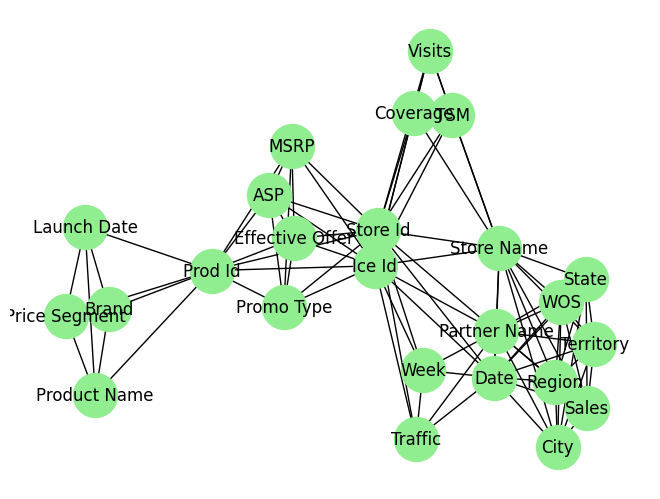

In [13]:

nx.draw(graph, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)

print('Node data')
for node in graph.nodes:
    print(node, graph.nodes[node])

print('Edge data')
for edge in graph.edges:
    print(edge, graph.edges[edge])

In [14]:
meta_store

{'metric': {'Sales': {'regexes': ['sales', 'sales?'],
   'Unique Values': [503.4091666666667],
   'GMD Name': 'Sales'},
  'WOS': {'regexes': ['wos', 'week of supply'],
   'Unique Values': [498.7225],
   'GMD Name': 'week of supply'},
  'MSRP': {'regexes': ['msrp'],
   'Unique Values': [705.5666666666667],
   'GMD Name': 'MSRP'},
  'ASP': {'regexes': ['asp'],
   'Unique Values': [668.6233333333333],
   'GMD Name': 'ASP'},
  'Traffic': {'regexes': ['Traffic', 'traffic'],
   'Unique Values': [4873868.61],
   'GMD Name': 'Traffic'}},
 'dimensions': {'City': {'regexes': ['city'],
   'Unique Values': ['Conklin',
    'Dougherty',
    'Hepler',
    'Lowry City',
    'Mode',
    'Scribner',
    'Searsboro',
    'Sturgeon Lake',
    'Volin',
    'Vulcan',
    'Cylinder',
    'Fortville',
    'Glen Ellyn',
    'Lublin',
    'North Royalton',
    'Pilot Mound',
    'Pleasant Plain',
    'Saint Bonifacius',
    'Trimont',
    'Villa Park',
    'Amesville',
    'Beverly Shores',
    'Champion',
    

Graph path error , initializing with empty d:\Smollan\titan_repo\titan\server\src\Utils\..\User_data/graphs\None
Meta data path error, initializing with empty  d:\Smollan\titan_repo\titan\server\src\Utils\..\User_data/meta_datas\None
Index(['City', 'Territory', 'State', 'Region', 'Partner Name', 'Store Name',
       'Date', 'Sales', 'WOS'],
      dtype='object')
City Territory
Added edge between City and Territory
City State
Added edge between City and State
City Region
Added edge between City and Region
City Partner Name
Added edge between City and Partner Name
City Store Name
Added edge between City and Store Name
City Date
Added edge between City and Date
City Sales
Added edge between City and Sales
City WOS
Added edge between City and WOS
Territory State
Added edge between Territory and State
Territory Region
Added edge between Territory and Region
Territory Partner Name
Added edge between Territory and Partner Name
Territory Store Name
Added edge between Territory and Store Name
T

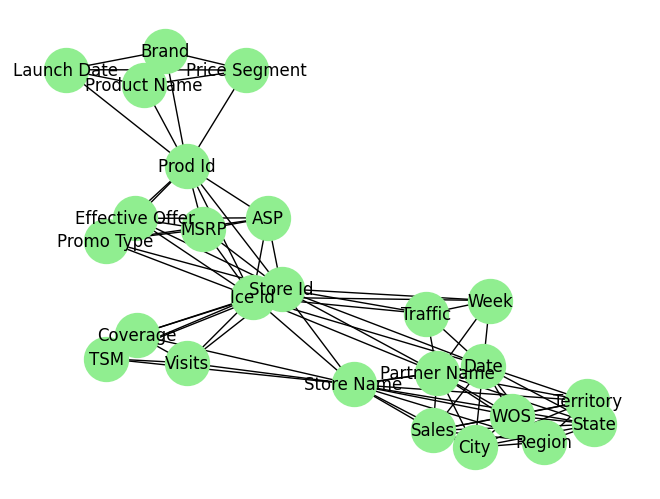

In [15]:
#Uses df from Arijit 
# We are storing only file name here, the code to store column name is commented out
import re
import itertools
import networkx as nx
from src.Utils.load_funcs import load_graph, load_meta_data
graph= load_graph('None')
id_graph = nx.Graph()
meta_store = load_meta_data('None')

def add_file_to_graph(df, file_name) -> None:
    global graph
    global meta_store
    global id_graph
    
    #Add nodes for each metric if it doesn't exist else add the file name to the list of file names
    list_of_metrics = []
    id_cols = []
    flag = 0
    print(df.columns)
    for col in df.columns:
        # print(col)
        for metric, regexes in gmd_dict['metric'].items():
            
            if any([re.search(r"\b{}\b".format(regex), col, re.IGNORECASE) for regex in regexes]):
                if col not in graph:
                    #if numeric, take mean val
                    if pd.api.types.is_numeric_dtype(df[col]):
                        mval = [int(val) if val.dtype == 'int64' else float(val) for val in  [df[col].mean()]][0]
                        unique_values = [mval]                    
                    elif pd.api.types.is_datetime64_any_dtype(df[col]):
                        min_date = df[col].min()
                        max_date = df[col].max()
                        unique_values = [min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d')]
                    else:
                        unique_values = list(df[col].unique())
                    
                    graph.add_node(col, file_names=[file_name])
                    id_graph.add_node(col, file_names=[file_name])

                    # graph.add_node(metric, file_names={file_name: col})
                else:
                    if file_name not in graph.nodes[col]['file_names']:
                        graph.nodes[col]['file_names'].append(file_name)
                        id_graph.nodes[col]['file_names'].append(file_name)
                        # graph.nodes[metric]['unique_values'].append(unique_values)
                        # graph.nodes[metric]['file_names'][file_name] = col
                if not col in meta_store['metric']:
                    meta_store['metric'][col] = {'regexes': list(set(regexes + [col.lower()])),'Unique Values': unique_values, 'GMD Name': metric}
                if not col in list_of_metrics:
                    list_of_metrics.append(col)
                flag = 1
                break
        
        if flag == 1:
            flag = 0
            continue
        for dimension, regexes in gmd_dict['dimensions'].items():

            if any([re.search(r"\b{}\b".format(regex), col, re.IGNORECASE) for regex in regexes]):
                #if numeric, take mean val
                if pd.api.types.is_numeric_dtype(df[col]):
                    mval = [int(val) if val.dtype == 'int64' else float(val) for val in  [df[col].mean()]][0]
                    unique_values = [mval] 
                elif pd.api.types.is_datetime64_any_dtype(df[col]):
                        min_date = df[col].min()
                        max_date = df[col].max()
                        unique_values = [min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d')]                  
                else:
                    unique_values = list(df[col].unique())
                
                if col not in graph:
                    
                    graph.add_node(col, file_names=[file_name])
                    id_graph.add_node(col, file_names=[file_name])
                    # graph.add_node(dimension, file_names={file_name: col})
                else:
                    if file_name not in graph.nodes[col]['file_names']:
                        graph.nodes[col]['file_names'].append(file_name)
                        id_graph.nodes[col]['file_names'].append(file_name)
                        # graph.nodes[dimension]['unique_values'].append(unique_values)
                        # graph.nodes[dimension]['file_names'][file_name] = col
                if not col in meta_store['dimensions']:
                    meta_store['dimensions'][col] = {'regexes': list(set(regexes + [col.lower()])),'Unique Values': unique_values, 'GMD Name': dimension}
                if not col in list_of_metrics:
                    list_of_metrics.append(col)
                ##LOCATION COLS
                if dimension in GLOBAL_LOCATIONS_SIGNIFIERS:
                    if col not in meta_store['Location Cols']:
                        meta_store['Location Cols'][col] = {'GMD Name': dimension}
                break
        #ID Check
        if any([re.search(r"\b{}\b".format(regex), col, re.IGNORECASE) for regex in gmd_dict['ID']]):
            ####
            id_cols.append(col)
            if col not in id_graph:
                id_graph.add_node(col, file_names=[file_name])
            else:
                if file_name not in id_graph.nodes[col]['file_names']:
                    id_graph.nodes[col]['file_names'].append(file_name)
            #### 
            if col not in graph:
                graph.add_node(col, file_names=[file_name])
            else:
                if file_name not in graph.nodes[col]['file_names']:
                    graph.nodes[col]['file_names'].append(file_name)
            if not col in list_of_metrics:
                list_of_metrics.append(col)

    if len(list_of_metrics)>=2:
        for node1, node2 in itertools.combinations(list_of_metrics, 2):
            print(node1, node2)
            if not node1 == node2:
                if not graph.has_edge(node1, node2):
                    graph.add_edge(node1, node2, file_names=[file_name])
                    print('Added edge between {} and {}'.format(node1, node2))
                else:
                    print(graph.get_edge_data(node1, node2))
                    if file_name not in graph.edges[node1, node2]['file_names']:
                        # graph.edges[node1, node2]['file_names'][file_name] = col
                        graph.edges[node1, node2]['file_names'].append(file_name)
                    print('Updated edge between {} and {}'.format(node1, node2))
                if node1 in id_cols or node2 in id_cols:
                    if not id_graph.has_edge(node1, node2):
                        id_graph.add_edge(node1, node2, file_names=[file_name])
                        print('Added id grph edge between {} and {}'.format(node1, node2))
                    else:
                        print(id_graph.get_edge_data(node1, node2))
                        if file_name not in id_graph.edges[node1, node2]['file_names']:
                            # graph.edges[node1, node2]['file_names'][file_name] = col
                            id_graph.edges[node1, node2]['file_names'].append(file_name)
                        print('Updated id grph edge between {} and {}'.format(node1, node2))

import os 
# for file in os.listdir('test_data_22_Aug'):
for file in os.listdir('src/User_data/file_datas'):
    df = pd.read_csv(f'src/User_data/file_datas/{file}')
    add_file_to_graph(df, file)


nx.draw(graph, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)

print('Node data')
for node in graph.nodes:
    print(node, graph.nodes[node])

print('Edge data')
for edge in graph.edges:
    print(edge, graph.edges[edge])

In [39]:
for key, meta_data in meta_store['metric'].items():
    print(key, meta_data)

for key, meta_data in meta_store['dimensions'].items():
    print(key, meta_data)

Sales {'regexes': ['sales', 'sales?'], 'Unique Values': [503.4091666666667], 'GMD Name': 'Sales'}
WOS {'regexes': ['week of supply', 'wos'], 'Unique Values': [498.7225], 'GMD Name': 'week of supply'}
MSRP {'regexes': ['msrp'], 'Unique Values': [705.5666666666667], 'GMD Name': 'MSRP'}
ASP {'regexes': ['asp'], 'Unique Values': [668.6233333333333], 'GMD Name': 'ASP'}
Traffic {'regexes': ['Traffic', 'traffic'], 'Unique Values': [4873868.61], 'GMD Name': 'Traffic'}
City {'regexes': ['city'], 'Unique Values': ['Conklin', 'Dougherty', 'Hepler', 'Lowry City', 'Mode', 'Scribner', 'Searsboro', 'Sturgeon Lake', 'Volin', 'Vulcan', 'Cylinder', 'Fortville', 'Glen Ellyn', 'Lublin', 'North Royalton', 'Pilot Mound', 'Pleasant Plain', 'Saint Bonifacius', 'Trimont', 'Villa Park', 'Amesville', 'Beverly Shores', 'Champion', 'Darfur', 'Drayton', 'Gilman', 'Hollansburg', 'Swaledale', 'Thompsonville', 'Twin Valley', 'Cherryville', 'Davey', 'Frazee', 'Granville', 'Houghton Lake', 'Humphrey', 'Ida Grove', 'Kiel

In [40]:
meta_store['Location Cols']

{'Territory': {'GMD Name': 'Location 1'}, 'Region': {'GMD Name': 'Location 2'}}

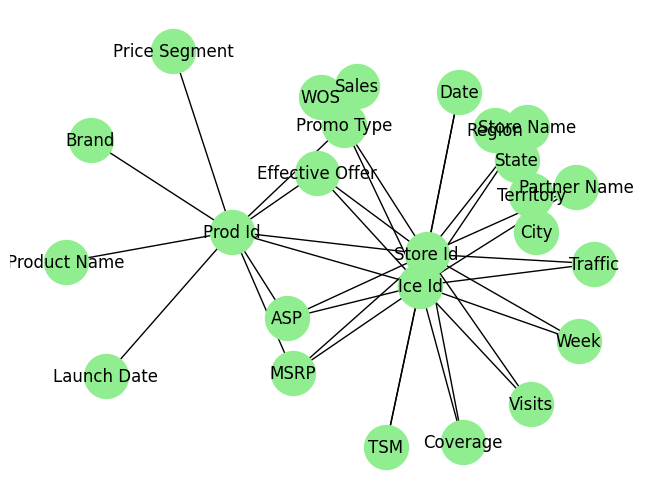

In [59]:
pos = nx.kamada_kawai_layout(id_graph)  # Deterministic layout
nx.draw(id_graph, pos, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)

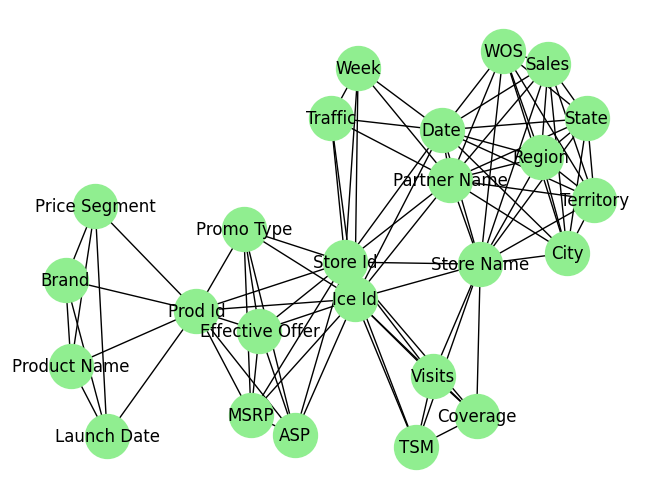

In [50]:
pos = nx.kamada_kawai_layout(graph)  # Deterministic layout
nx.draw(graph, pos, with_labels=True, node_color='lightgreen', node_size=1000, font_size=12)

In [61]:
#save metadata
import json
with open('src/User_data/meta_datas/test_meta_data.json', 'w') as fp:
    json.dump(meta_store, fp)

In [62]:
company_name  = 'test'
#sAVE graph
nx.write_gml(graph, f"src/User_data/graphs/{company_name}_graph.gml")

In [60]:
nx.write_gml(id_graph, f"src/User_data/graphs/{company_name}_id_graph.gml")

In [51]:
# import re
# import itertools
# import networkx as nx
# graph= nx.Graph()
# def add_file_to_graph(df, file_name) -> None:
#     global graph
#     #Add nodes for each metric if it doesn't exist else add the file name to the list of file names
#     list_of_metrics = []
#     print(df.columns)
#     for col in df.columns:
#         # print(col)
#         for metric, regexes in gmd_dict['metric'].items():
#             regexes = regexes['regexes']
#             if any([re.search(r"\b{}\b".format(regex), col, re.IGNORECASE) for regex in regexes]):
#                 print(col)
#                 if metric not in graph:
#                     graph.add_node(metric, file_names=[file_name])
#                 else:
#                     if file_name not in graph.nodes[metric]['file_names']:
#                         graph.nodes[metric]['file_names'].append(file_name)
#                 if not metric in list_of_metrics:
#                     list_of_metrics.append(metric)
#     # print(list_of_metrics)
# #     print(list_of_metrics)
#     #Add edge for each metric
#     if len(list_of_metrics)>=2:
#         for node1, node2 in itertools.combinations(list_of_metrics, 2):
#             print(node1, node2)
#             if not node1 == node2:
#                 if not graph.has_edge(node1, node2):
#                     graph.add_edge(node1, node2, file_names=[file_name])
#                     print('Added edge between {} and {}'.format(node1, node2))
#                 else:
#                     print(graph.get_edge_data(node1, node2))
#                     if file_name not in graph.get_edge_data[node1, node2]['file_names']:
#                         graph.edges[node1, node2]['file_names'].append(file_name)
#                     print('Updated edge between {} and {}'.format(node1, node2))

# add_file_to_graph(df1, 'file1')
# add_file_to_graph(df2, 'file2')
# add_file_to_graph(df3, 'file3')


# nx.draw(graph, with_labels=True, node_color='lightgreen', node_size=2000, font_size=12)

# print('Node data')
# for node in graph.nodes:
#     print(node, graph.nodes[node])

# print('Edge data')
# for edge in graph.edges:
#     print(edge, graph.edges[edge])

# Some dummy data updates(Ignore)

In [37]:
df = pd.read_csv('test_data_16_Aug/Store data_dummy_16_aug.csv')

In [38]:
import random
def random_region(x):
    list_of_regions = ['west', 'east', 'north', 'south', 'central']
    return random.choice(list_of_regions)


df['Region'] = df['Region'].apply(random_region)
df

,UID,City,Region,State,Store Name,TSM,Coverage,Tier,Visits,Partner Name,Country,Sales
0,1,Pencil Bluff,central,Arkansas,"Costco,Pencil Bluff,Montgomery,Arkansas,US",Makayla Avery,Uncovered,2,0,Costco,US,65993
1,2,Le Roy,south,West Virginia,"Costco,Le Roy,Jackson,West Virginia,US",Jakari Li,Covered,3,13,Costco,US,40265
2,3,Port Republic,west,Maryland,"Amazon,Port Republic,Calvert,Maryland,US",Paige Sosa,Uncovered,2,0,Amazon,US,88201
3,4,Crescent Mills,west,California,"Target,Crescent Mills,Plumas,California,US",Emir Livingston,Uncovered,2,10,Target,US,99680
4,5,Browntown,east,Wisconsin,"Target,Browntown,Green,Wisconsin,US",Milena Rose,Uncovered,2,3,Target,US,91109
...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,Kincheloe,south,Michigan,"Costco,Kincheloe,Chippewa,Michigan,US",Zoya Bush,Covered,2,0,Costco,US,70460
296,297,Slatersville,west,Rhode Island,"Walmart,Slatersville,Providence,Rhode Island,US",Brennan Ayala,Covered,2,5,Walmart,US,75482
297,298,Austin,west,Nevada,"Amazon,Austin,Lonoke,Nevada,US",Tyson Jarvis,Covered,2,9,Amazon,US,51983
298,299,Beaverton,south,Michigan,"Walmart,Beaverton,Lamar,Michigan,US",Elisabeth Farley,Uncovered,2,6,Walmart,US,58878


In [39]:
df2 = pd.read_csv('test_data_16_Aug/Promo data_dummy_16_aug.csv')

In [40]:
df2['Region'] = df2['Region'].apply(random_region)
df2

,UID,Date,Week,City,Region,State,Country,Store Name,Coverage,Brand,Product Name,Partner Name,Promo Type,Effective Offer,MSRP,ASP
0,1,55:52.3,48,Pencil Bluff,east,Arkansas,US,"Costco,Pencil Bluff,Montgomery,Arkansas,US",Uncovered,Asus,Asus Zenbook,Costco,NaN,NaN,300,266
1,2,29:41.9,27,Le Roy,north,West Virginia,US,"Costco,Le Roy,Jackson,West Virginia,US",Covered,Asus,Asus TUF Gaming,Costco,Coupons,$24,400,392
2,3,54:42.2,23,Port Republic,west,Maryland,US,"Amazon,Port Republic,Calvert,Maryland,US",Uncovered,HP,HP Envy x360,Amazon,NaN,NaN,600,509
3,4,40:12.6,1,Crescent Mills,north,California,US,"Target,Crescent Mills,Plumas,California,US",Uncovered,Samsung,Samsung Galaxybook,Target,NaN,NaN,1000,930
4,5,32:17.3,26,Browntown,north,Wisconsin,US,"Target,Browntown,Green,Wisconsin,US",Uncovered,Microsoft,Microsoft Surface Pro,Target,Loyalty Program,$12,900,863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,21:37.2,22,Kincheloe,west,Michigan,US,"Costco,Kincheloe,Chippewa,Michigan,US",Covered,HP,HP Envy x360,Costco,NaN,NaN,600,518
296,297,02:05.9,26,Slatersville,central,Rhode Island,US,"Walmart,Slatersville,Providence,Rhode Island,US",Covered,Asus,Asus Zenbook,Walmart,Gift Card,$222,300,294
297,298,49:21.1,49,Austin,north,Nevada,US,"Amazon,Austin,Lonoke,Nevada,US",Covered,Asus,Asus Zenbook,Amazon,Gift Card,$159,300,281
298,299,04:44.5,19,Beaverton,central,Michigan,US,"Walmart,Beaverton,Lamar,Michigan,US",Uncovered,HP,HP Envy x360,Walmart,Loyalty Program,$43,600,537


In [41]:
df.to_csv('test_data_16_Aug/Store data_dummy_16_aug.csv', index=False)
df2.to_csv('test_data_16_Aug/Promo data_dummy_16_aug.csv', index=False)

In [114]:
import re
#Check time for each part of func


def separate_exception_entities(sentence, entities):
    # Regex pattern to capture entities after "except" until "and", then a single word after "and"
    pattern = r'except\s*(.*?)\s+and\s+(\w+)'
    
    # Find matches using the pattern
    match = re.search(pattern, sentence, re.IGNORECASE)
    exception_entities = []
    if match:
        
        # First group captures entities before "and"
        before_and_entities = match.group(1)
        # Second group captures the single entity after "and"
        after_and_entity = match.group(2)
        
        # Split entities before "and" based on commas and spaces
        if before_and_entities:
            exception_entities.extend([entity.strip() for entity in re.split(r'[,\s]+', before_and_entities) if entity])
        
        # Add the single entity after "and"
        if after_and_entity:
            exception_entities.append(after_and_entity.strip())


    # Classify entities into exception and non-exception lists
    non_exception_entities = [entity for entity in entities if entity.lower() not in exception_entities]
    
    return exception_entities, non_exception_entities


sentence = "all sales except bby, amazon and verizon in west region"
entities = ["bby", "verizon", 'amazon', "west region"]
exceptions, non_exceptions = separate_exception_entities(sentence, entities)
print("Exceptions:", exceptions)
print("Non-Exceptions:", non_exceptions)

Exceptions: ['bby', 'amazon', 'verizon']
Non-Exceptions: ['west region']


In [41]:
import re

def extract_comparisons(sentence, entities):
    # Regular expression pattern to match phrases like "X is greater than 10" or "Y is less than 50"
    pattern = r'(\w*\s*\w+)(?:\s*data)?\s*(?:is|have|has|are)?\s+(greater than or equals? to|less than or equals? to|greater(?: than)?|less(?: than)?|equals?(?: to)?|>|<|=|)\s*(\d+)'
    extracted_info = []

    # Find all matches in the sentence
    matches = re.findall(pattern, sentence, re.IGNORECASE)
    for match in matches:
        entity, comparison, number = match

        # Normalize the comparison phrases to their symbolic equivalents
        if comparison == "greater than or equal to" or comparison == "greater than or equals to":
            comparison = ">="
        if comparison == "less than or equal to" or comparison == "less than or equals to":
            comparison = "<="
        elif 'greater' in comparison.lower():
            comparison = ">"
        elif 'less' in comparison.lower():
            comparison = "<"
        else:
            comparison = "=="
        for ent in entities:
            if re.search(r"\b{}\b".format(ent), entity, re.IGNORECASE):
                extracted_info.append([ent, comparison, int(number)])

    return extracted_info

sentence = "which bby stores have Sales data greater than 1000, advocate count less than 100, gfa equals 1000 and asp less than or equal to 1000"
extracted_info = extract_comparisons(sentence, ['sales', 'asp', 'gfa', 'advocate count'])
print(extracted_info)


[['sales', '>', 1000], ['advocate count', '<', 100], ['gfa', '==', 1000], ['asp', '<=', 1000]]


In [87]:

def extract_aggregations(sentence, entities):
    pat = r'(\w*\s*\w+)?\s*(mean|ave?r?a?ge?|median|mode|sum|counts?|min|max)\s*(?:of|for)?\s+(\w+\s*\w*)'
    extracted_info = {}
    matches = re.findall(pat, sentence, re.IGNORECASE)
    for match in matches:
        if len(match)== 3:
            entity1, agg, entity2 = match
        elif len(match) == 2:
            entity1 = ''
            agg, entity2 = match
        else:
            return extracted_info
        # print(entity1, agg, entity2)
        for ent in entities:
            if agg.lower() not in ['median', 'mode', 'sum', 'count', 'counts', 'min', 'max']:
                agg = 'mean'
            if re.search(r"\b{}\b".format(ent), entity2, re.IGNORECASE):
                if entity2 == '':
                    continue
                entity2 = re.split(r"\b{}\b".format(ent), entity2)[0]
                
                # extracted_info.append([ent, agg, entity1])
                extracted_info[match] = [agg, ent, 2]
                
            elif re.search(r"\b{}\b".format(ent), entity1, re.IGNORECASE):
                if entity1 == '':
                    continue
                entity1 = re.split(r"\b{}\b".format(ent), entity1)[1]

                if match in extracted_info:
                    level = extracted_info[match][2]
                    if level == 2:
                        continue

                # extracted_info.append([ent, agg, entity1])
                extracted_info[match] = [agg, ent, 1]
    fin = []
    for val in extracted_info.values():
        fin+=[val[:2]]
            
    return fin

sentence = 'give traffic max sales and counts for visits for tsm'
extracted_info = extract_aggregations(sentence, ['sales', 'tsm', 'traffic', 'visits'])
extracted_info

[['max', 'sales'], ['counts', 'visits']]

In [96]:
'10'.isdigit()

True

In [109]:
def extract_top_or_bottom_n(sentence):
    pat = r'(top|bottom|first|last|largest|smallest|worst|best(?!\sbuy)|highest|lowest)\s+(\d+)|(\d+)\s+(top|bottom|first|last|largest|smallest|worst|best(?!\sbuy)|highest|lowest)'
    extracted_info = {}

    matches = re.search(pat, sentence, re.IGNORECASE)

    if matches:
        top_or_bottom = matches.group(1)
        if not top_or_bottom:
            top_or_bottom = matches.group(4)
            n = int(matches.group(3))
        else:
            n = int(matches.group(2))

        if top_or_bottom.lower() in ['top', 'largest', 'first' ]:
            top_or_bottom = 'top'
        elif top_or_bottom.lower() in ['bottom', 'last', 'smallest']:
            top_or_bottom = 'bottom'
        
        extracted_info = [top_or_bottom, n]
    else:
        pat2 = r'\b(top|bottom|first|last|largest|smallest|worst|best(?!\sbuy)|highest|lowest|ascending order|descending order)\b'
        matches2 = re.search(pat2, sentence, re.IGNORECASE)
        if matches2:
            top_or_bottom = matches2.group(1)
            n = None
            if top_or_bottom.lower() in ['top', 'largest', 'first', 'highest', 'best', 'ascending order']:
                top_or_bottom = 'top'
            elif top_or_bottom.lower() in ['bottom', 'last', 'smallest', 'worst', 'lowest', 'descending order']:
                top_or_bottom = 'bottom'
            extracted_info = [top_or_bottom, n]
    return extracted_info


sentence = 'worst sales for best buy'
extracted_info = extract_top_or_bottom_n(sentence)
extracted_info

['bottom', None]

In [7]:
from dateparser.search import search_dates

text = "Our next meeting is scheduled for Q3 2024, or maybe next week."
date = search_dates(text)

if date:
    for parsed_date in date:
        print(f"Detected date: {parsed_date[0]} -> Parsed as: {parsed_date[1]}")
else:
    print("No date found in the text.")


Detected date: 2024 -> Parsed as: 2024-08-22 00:00:00


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
text = "Our next meeting is scheduled for Q3 2024, or maybe next week."
doc = nlp(text)

dates = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
print(dates)


In [20]:
text = "Give me data for 22-12-2022"
doc = nlp(text)

dates = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
print(dates)

[]


In [34]:

text = "Our next meeting is scheduled for Q3 2024, or 22-2-22."
sentence = Sentence(text)
tagger.predict(sentence)

# Extract dates
dates = [entity.text for entity in sentence.get_spans('ner') if entity.tag == 'DATE']

print(dates)

['Q3 2024']
